# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
#from scipy.misc import  imresize
#from scipy.misc.pilutil import imread, 
from skimage.transform import resize, rescale
from matplotlib.pyplot import imread
import datetime
import os
import tensorflow as tf
print(tf.__version__)
import pathlib

2.7.0


We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
data_dir_train = pathlib.Path("datasets/Project_data/train")
data_dir_val = pathlib.Path("datasets/Project_data/val")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.png')))
print(image_count_train)
image_count_val = len(list(data_dir_val.glob('*/*.png')))
print(image_count_val)

19890
3000


In [6]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())

In [12]:
def sequence (num_ephos, batch_size):
        curr_dt_time = datetime.datetime.now()
        train_path = 'datasets/Project_data/train'
        val_path = 'datasets/Project_data/val'
        num_train_sequences = len(train_doc)
        print('# training sequences =', num_train_sequences)
        num_val_sequences = len(val_doc)
        print('# validation sequences =', num_val_sequences)
        num_epochs = num_ephos
        print ('# epochs =', num_epochs)
        print('#batch size', batch_size)
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
        
        return steps_per_epoch, validation_steps,num_epochs

In [7]:
#Defining batch size and number of epochs, getting steps per epochs for training and validation
batch_size = 64
number_epochs = 25
d = sequence(number_epochs,batch_size)
steps_per_epoch = d[0]
validation_steps = d[1]
num_epochs = d[2]

print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)
print(num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25
#batch size 64
steps_per_epoch 11
validation_steps 2
25


In [9]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from skimage.transform import resize

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [14]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,84,84,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [19]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
#model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [26]:
sgd = tf.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization_4 (Batc  (None, 18, 84, 84, 64)   256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 42, 84, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_5 (Batc  (None, 9, 42, 84, 128)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [33]:
model_name = 'model_init_Conv3d' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [30]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [34]:
model1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_387/4091165505.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.6109 - categorical_accuracy: 0.1810
Epoch 00001: saving model to model_init_Conv3d_2023-09-3005_04_11.720532/model-00001-1.61092-0.18100-1.61481-0.22000.h5
11/11 [==============================] - 100s 10s/step - loss: 1.6109 - categorical_accuracy: 0.1810 - val_loss: 1.6148 - val_categorical_accuracy: 0.2200 - lr: 1.2500e-04
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.6129 - categorical_accuracy: 0.1991
Epoch 00002: saving model to model_init_Conv3d_2023-09-3005_04_11.720532/model-00002-1.61288-0.19910-1.60813-0.22000.h5
11/11 [==============================] - 94s 9s/step - loss: 1.6129 - categorical_accuracy: 0.1991 - val_loss: 1.6081 - val_categorical_accuracy: 0.2200 - lr: 1.2500e-04
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.6135 - categorical_accuracy: 0.1931
Epoch 00003: saving model to model_init_Conv3d_2023-09-3005_04_11.720532/model-00003-1.61353-0.19306

In [38]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


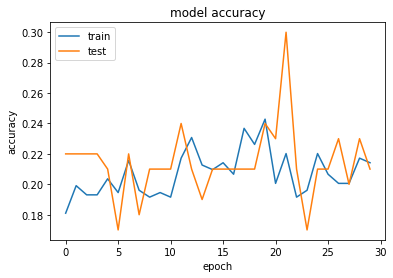

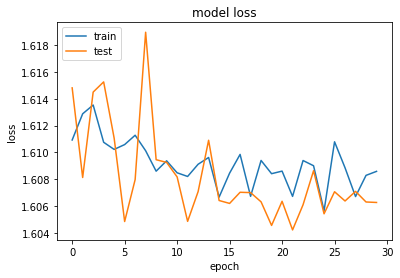

In [36]:
plot_loss_accuracy(model1)

In [8]:
from PIL import Image
from sklearn.preprocessing import normalize


img_idx = img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
x=120
y=120
lenght=len(img_idx)
sample_shape=(len(img_idx),x,y,3)
resize_shape=(x,y)

def generator2(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    while True:
    
        t = np.random.permutation(folder_list) #663 for train
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(str(source_path)+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = Image.open(str(source_path)+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    if(image.size[1]>x):
                       # left = 20
                       # top = 50
                       # right = 300
                       # bottom = 350
                       # image=image.crop((left, top, right, bottom))
                       image=image.resize(resize_shape)
                        
                        
                    else:
                        image=image.resize(resize_shape)
                        
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = normalize(np.array(image)[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize(np.array(image)[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize(np.array(image)[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size!=0):
            batch_data = np.zeros((len(t)%batch_size,len(img_idx),x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(str(source_path)+'/'+ t[folder + num_batches*batch_size].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = Image.open(str(source_path)+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    if(image.size[1]>x):
                        image=image.resize(resize_shape)
                    else:
                        image=image.resize(resize_shape)
                        
                        
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                   
                    batch_data[folder,idx,:,:,0] = normalize(np.array(image)[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize(np.array(image)[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize(np.array(image)[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [54]:
model = Sequential()

model.add(Conv3D(16, kernel_size=(3, 3, 3), input_shape=(18, 120, 120, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5))
model.add(Activation('softmax'))

In [11]:
#Defining batch size and number of epochs, getting steps per epochs for training and validation
batch_size = 20
number_epochs = 25
d = sequence(number_epochs,batch_size)
steps_per_epoch = d[0]
validation_steps = d[1]
num_epochs = d[2]

print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)
print(num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25
#batch size 20
steps_per_epoch 34
validation_steps 5
25


In [12]:
#Initianlizing reain and validation generation with new generator fuction
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
train_generator = generator2(train_path, train_doc, batch_size)
val_generator = generator2(val_path, val_doc, batch_size)

In [57]:
#Changing optimizer to ADAM
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 120, 120, 16)  1312      
                                                                 
 activation_18 (Activation)  (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_16 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 60, 60, 32)     13856     
                                                                 
 activation_19 (Activation)  (None, 9, 60, 60, 32)    

In [58]:
model_name = 'model_Conv3d_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [43]:
model2 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6701 - categorical_accuracy: 0.4072Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_Conv3d_2_2023-09-3005_07_04.138933/model-00001-1.67011-0.40724-2.12977-0.21000.h5
34/34 [==============================] - 56s 2s/step - loss: 1.6701 - categorical_accuracy: 0.4072 - val_loss: 2.1298 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.9673 - categorical_accuracy: 0.6410
Epoch 00002: saving model to model_Conv3d_2_2023-09-3005_07_04.138933/model-00002-0.96733-0.64103-3.18615-0.20000.h5
34/34 [==============================] - 52s 2s/step - loss: 0.9673 - categorical_accuracy: 0.6410 - val_loss: 3.1862 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.7061 - categorical_accuracy: 0.7

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


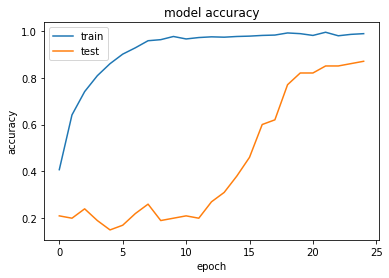

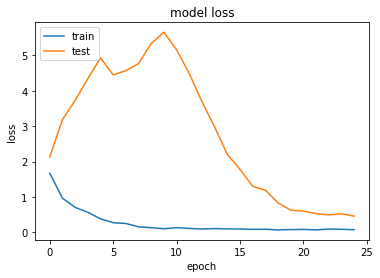

In [44]:
plot_loss_accuracy(model2)

In [18]:
#Defining batch size and number of epochs, getting steps per epochs for training and validation
batch_size =20
number_epochs = 25
d = sequence(number_epochs,batch_size)
steps_per_epoch = d[0]
validation_steps = d[1]
num_epochs = d[2]

print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)
print(num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25
#batch size 20
steps_per_epoch 34
validation_steps 5
25


In [20]:
#increasing dropout after dense layer
model = Sequential()

model.add(Conv3D(16, kernel_size=(3, 3, 3), input_shape=(18, 120, 120, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5))
model.add(Activation('softmax'))

In [21]:
#Model COmpilation
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 18, 120, 120, 16)  1312      
                                                                 
 activation_5 (Activation)   (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 18, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 9, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 9, 60, 60, 32)     13856     
                                                                 
 activation_6 (Activation)   (None, 9, 60, 60, 32)    

In [52]:
# Define the directory for saving model checkpoints
curr_dt_time = datetime.datetime.now()
model_name = 'model_conv3D_3' + 'new'+ '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the filepath format for saving checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Create the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=False, 
    save_weights_only=False, 
    mode='auto', 
    period=1
)
callbacks_list = [checkpoint, LR]

In [70]:
model3 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.2465 - categorical_accuracy: 0.2911
Epoch 00001: saving model to model_conv3D_3new_2023-09-3008_40_55.635607/model-00001-2.24645-0.29110-2.05127-0.15000.h5
34/34 [==============================] - 52s 2s/step - loss: 2.2465 - categorical_accuracy: 0.2911 - val_loss: 2.0513 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.7871 - categorical_accuracy: 0.4012
Epoch 00002: saving model to model_conv3D_3new_2023-09-3008_40_55.635607/model-00002-1.78707-0.40121-2.34309-0.22000.h5
34/34 [==============================] - 51s 2s/step - loss: 1.7871 - categorical_accuracy: 0.4012 - val_loss: 2.3431 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.4685 - categorical_accuracy: 0.4872
Epoch 00003: saving model to model_conv3D_3new_2023-09-3008_40_55.635607/model-00003-1.46854-0.48718-2.51750-0

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


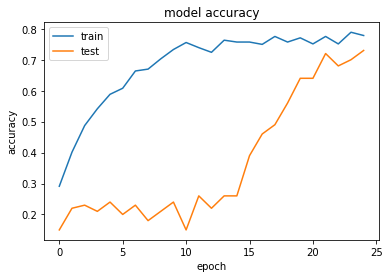

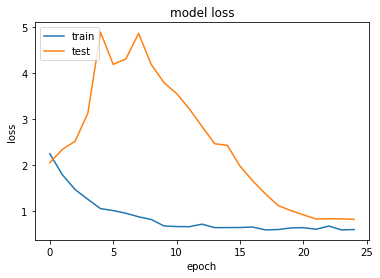

In [71]:
plot_loss_accuracy(model3)

In [63]:
img_idx = [int(i) for i in range(0,30,2)] #create a list of image numbers you want to use for a particular video
x=120
y=120
lenght=len(img_idx)
sample_shape=(len(img_idx),x,y,3)
resize_shape=(x,y)

def generator3(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    while True:
    
        t = np.random.permutation(folder_list) #663 for train
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(str(source_path)+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = Image.open(str(source_path)+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    if(image.size[1]>x):
                       # left = 20
                       # top = 50
                       # right = 300
                       # bottom = 350
                       # image=image.crop((left, top, right, bottom))
                       image=image.resize(resize_shape)
                        
                        
                    else:
                        image=image.resize(resize_shape)
                        
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = normalize(np.array(image)[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize(np.array(image)[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize(np.array(image)[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size!=0):
            batch_data = np.zeros((len(t)%batch_size,len(img_idx),x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(str(source_path)+'/'+ t[folder + num_batches*batch_size].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = Image.open(str(source_path)+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    if(image.size[1]>x):
                        image=image.resize(resize_shape)
                    else:
                        image=image.resize(resize_shape)
                        
                        
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                   
                    batch_data[folder,idx,:,:,0] = normalize(np.array(image)[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize(np.array(image)[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize(np.array(image)[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [64]:
train_generator = generator3(data_dir_train, train_doc, batch_size)
val_generator = generator3(data_dir_val, val_doc, batch_size)
d = next(train_generator)[0]

Source path =  datasets/Project_data/train ; batch size = 64


In [65]:
#Defining batch size and number of epochs, getting steps per epochs for training and validation
batch_size = 64
number_epochs = 30
d = sequence(number_epochs,batch_size)
steps_per_epoch = d[0]
validation_steps = d[1]
num_epochs = d[2]

print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)
print(num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30
#batch size 64
steps_per_epoch 11
validation_steps 2
30


In [28]:
# create a Mobile Net "model", we will use
# image with shape (224, 224, 3)
mnet =tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(x, y, 3)
)

# do not train first layers, I want to only train
# the 4 last layers (my own choice, up to you)
for layer in mnet.layers[:-4]:
    layer.trainable = False
# create a Sequential model
model = Sequential()

model.add(
    TimeDistributed(mnet, input_shape=(lenght, x, y, 3))
)

model.add(Dropout(.5))

# now, flatten on each output to send 5 
# outputs with one dimension to LSTM
model.add(TimeDistributed(Flatten()))

model.add(Dropout(.5))

model.add(GRU(512,activation='relu', return_sequences=False))

# finalize with standard Dense, Dropout...
model.add(Dropout(.5))

model.add(Dense(256, activation='relu'))

model.add(Dropout(.5))

model.add(Dense(5, activation='softmax'))

In [29]:
optimiser =tf.optimizers.Adam(lr=.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 dropout_4 (Dropout)         (None, 15, 3, 3, 1024)    0         
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 9216)         0         
 tributed)                                                       
                                                                 
 dropout_5 (Dropout)         (None, 15, 9216)          0         
                                                                 
 gru_1 (GRU)                 (None, 512)               14945280  
                                                                 
 dropout_6 (Dropout)         (None, 512)              

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [30]:
model_name = 'model_GRU_mnet' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name +'GesRegV1' + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [72]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [34]:
model4=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_309/784220664.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model4=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 5.6311 - categorical_accuracy: 0.2504Source path =  datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 1.37748, saving model to model_GRU_mnet_2023-09-3008_01_50.796357/GesRegV1model-00001-5.63111-0.25038-1.37748-0.41000.h5
11/11 [==============================] - 48s 4s/step - loss: 5.6311 - categorical_accuracy: 0.2504 - val_loss: 1.3775 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 2.8866 - categorical_accuracy: 0.3710
Epoch 00002: val_loss improved from 1.37748 to 1.25027, saving model to model_GRU_mnet_2023-09-3008_01_50.796357/GesRegV1model-00002-2.88657-0.37104-1.25027-0.47000.h5
11/11 [==============================] - 43s 4s/step - loss: 2.8866 - categorical_accuracy: 0.3710 - val_loss: 1.2503 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - los

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


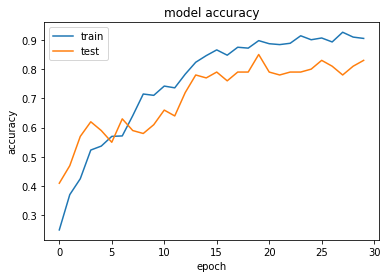

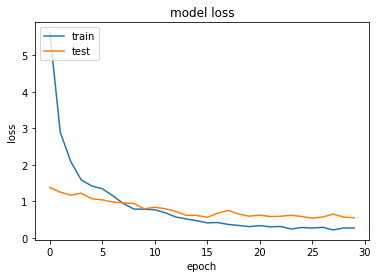

In [37]:
plot_loss_accuracy(model4)

In [28]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                 input_shape=(lenght, x, y, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))


model.add(GRU(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

       

In [30]:
optimiser = tf.optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
model_name = 'model_LSTM_GRU' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name +'GesRegV1' + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [36]:
model7 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

2023-10-02 10:12:50.304362: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 165888000 exceeds 10% of free system memory.


Epoch 1/30


2023-10-02 10:12:52.405787: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 165888000 exceeds 10% of free system memory.
2023-10-02 10:12:53.609315: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2023-10-02 10:12:55.866636: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 165888000 exceeds 10% of free system memory.


 2/11 [====>.........................] - ETA: 11s - loss: 2.0500 - categorical_accuracy: 0.1953 

2023-10-02 10:13:01.209374: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 165888000 exceeds 10% of free system memory.


 3/11 [=======>......................] - ETA: 20s - loss: 1.9484 - categorical_accuracy: 0.2344

2023-10-02 10:13:04.392166: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 165888000 exceeds 10% of free system memory.


11/11 [==============================] - ETA: 0s - loss: 1.6691 - categorical_accuracy: 0.3122Source path =  datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 1.61420, saving model to model_LSTM_GRU_2023-10-0210_10_24.934289/GesRegV1model-00001-1.66911-0.31222-1.61420-0.21000.h5
11/11 [==============================] - 46s 4s/step - loss: 1.6691 - categorical_accuracy: 0.3122 - val_loss: 1.6142 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.1964 - categorical_accuracy: 0.5204
Epoch 00002: val_loss did not improve from 1.61420
11/11 [==============================] - 40s 4s/step - loss: 1.1964 - categorical_accuracy: 0.5204 - val_loss: 1.6433 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.9702 - categorical_accuracy: 0.6652
Epoch 00003: val_loss did not improve from 1.61420

Epoch 00003: ReduceLROnPlat

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


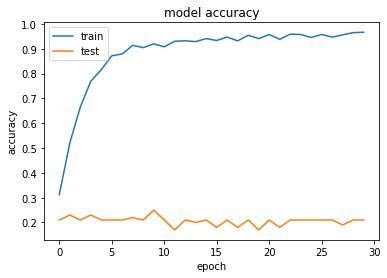

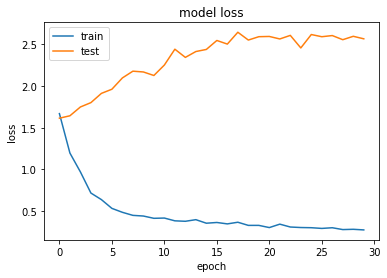

In [39]:
plot_loss_accuracy(model7)

In [48]:
#increasing dropout after dense layer
model = Sequential()

model.add(Conv3D(16, kernel_size=(2, 2, 2), input_shape=(18, 120, 120, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5))
model.add(Activation('softmax'))

In [49]:
optimiser = tf.optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [50]:
model_name = 'model_Conv3D_2Filter' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name +'GesRegV1' + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [51]:
model9 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.3382 - categorical_accuracy: 0.2836Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 2.20337, saving model to model_Conv3D_2Filter_2023-10-0210_10_24.934289/GesRegV1model-00001-2.33818-0.28356-2.20337-0.16000.h5
34/34 [==============================] - 51s 2s/step - loss: 2.3382 - categorical_accuracy: 0.2836 - val_loss: 2.2034 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5406 - categorical_accuracy: 0.4721
Epoch 00002: val_loss did not improve from 2.20337
34/34 [==============================] - 49s 1s/step - loss: 1.5406 - categorical_accuracy: 0.4721 - val_loss: 3.6877 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3388 - categorical_accuracy: 0.5234
E

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


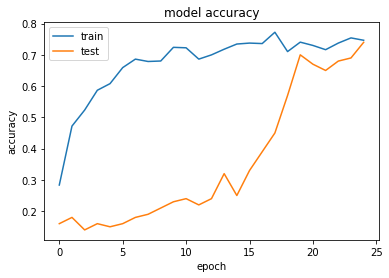

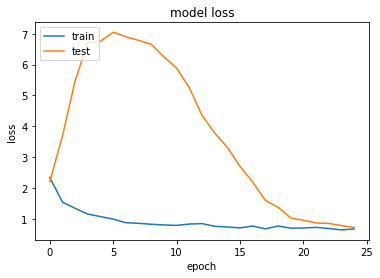

In [53]:
plot_loss_accuracy(model9)

In [54]:
#Defining batch size and number of epochs, getting steps per epochs for training and validation
batch_size = 64
number_epochs = 30
d = sequence(number_epochs,batch_size)
steps_per_epoch = d[0]
validation_steps = d[1]
num_epochs = d[2]

print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)
print(num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30
#batch size 64
steps_per_epoch 11
validation_steps 2
30


In [56]:
#increasing dropout after dense layer
model = Sequential()

model.add(Conv3D(16, kernel_size=(2, 2, 2), input_shape=(18, 120, 120, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(256, kernel_size=(2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5))
model.add(Activation('softmax'))

In [57]:
optimiser = tf.optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [58]:
model_name = 'model_Conv3D_2Filter_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name +'GesRegV1' + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [59]:
model10 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 2.6900 - categorical_accuracy: 0.2273
Epoch 00001: val_loss improved from inf to 1.61100, saving model to model_Conv3D_2Filter_2_2023-10-0210_59_50.556223/GesRegV1model-00001-2.68998-0.22727-1.61100-0.25000.h5
11/11 [==============================] - 18s 2s/step - loss: 2.6900 - categorical_accuracy: 0.2273 - val_loss: 1.6110 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 2.3071 - categorical_accuracy: 0.3091
Epoch 00002: val_loss did not improve from 1.61100
11/11 [==============================] - 17s 2s/step - loss: 2.3071 - categorical_accuracy: 0.3091 - val_loss: 1.8445 - val_categorical_accuracy: 0.0750 - lr: 2.0000e-04
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.8071 - categorical_accuracy: 0.4236
Epoch 00003: val_loss did not improve from 1.61100

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.99999974

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


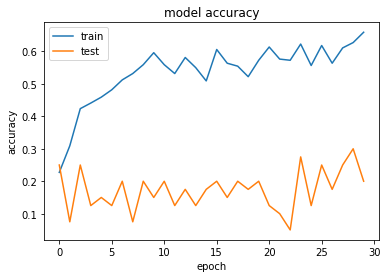

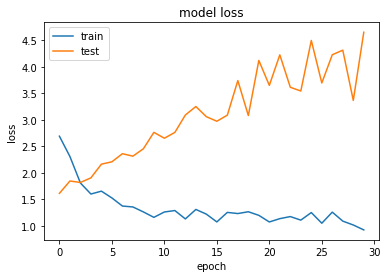

In [61]:
plot_loss_accuracy(model10)

In [73]:
#increasing dropout after dense layer
model = Sequential()

model.add(Conv3D(16, kernel_size=(2, 2, 2), input_shape=(18, 120, 120, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5))
model.add(Activation('softmax'))

In [74]:
optimiser = tf.optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [75]:
model_name = 'model_Conv3D_2Filter_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name +'GesRegV1' + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [79]:
#Defining batch size and number of epochs, getting steps per epochs for training and validation
batch_size = 32
number_epochs = 30
d = sequence(number_epochs,batch_size)
steps_per_epoch = d[0]
validation_steps = d[1]
num_epochs = d[2]

print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)
print(num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30
#batch size 32
steps_per_epoch 21
validation_steps 4
30


In [83]:
model11 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.8499 - categorical_accuracy: 0.6938Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss did not improve from inf
21/21 [==============================] - 50s 2s/step - loss: 0.8499 - categorical_accuracy: 0.6938 - val_loss: nan - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.5326 - categorical_accuracy: 0.8024
Epoch 00002: val_loss did not improve from inf

Epoch 00002: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
21/21 [==============================] - 49s 2s/step - loss: 0.5326 - categorical_accuracy: 0.8024 - val_loss: nan - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.3228 - categorical_accuracy: 0.8929
Epoch 00003: val_loss did not improve from inf
21/21 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


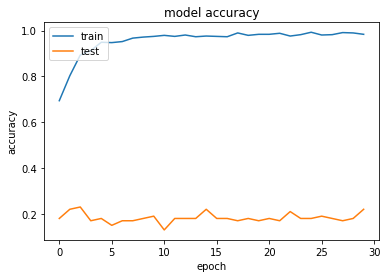

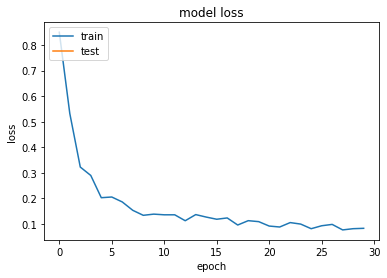

In [84]:
plot_loss_accuracy(model11)

In [31]:
### Reducing model Complexity, decreasing GRU units and increasing initial learning rate to 0.001

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

In [16]:
from keras.applications import mobilenet
def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.5, num_images=18, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(5, activation='softmax'))

    opt = tf.optimizers.Adam(lr=0.001) #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model



In [24]:
#Defining batch size and number of epochs, getting steps per epochs for training and validation
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
batch_size = 32
number_epochs = 25
d = sequence(number_epochs,batch_size)
steps_per_epoch = d[0]
validation_steps = d[1]
num_epochs = d[2]
num_frames = 18

print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)
print(num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25
#batch size 32
steps_per_epoch 21
validation_steps 4
25


In [25]:
train_generator = generator2(train_path, train_doc, batch_size)
val_generator = generator2(val_path, val_doc, batch_size)

In [26]:
model12 = mobilenet_RNN(gru=True, num_images=num_frames)
print(model12.summary())

Number of layers in the pretrained mobilenet model:  86
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 18, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 18, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 18, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 18, 1024)         0         
 tributed)                                                       
                                                                

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_mobilenet_GRU' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name +'GesRegV1' + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [28]:
model12 = model12.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6063 - categorical_accuracy: 0.3439Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.89694, saving model to model_mobilenet_GRU_2023-10-0213_18_24.304293/GesRegV1model-00001-1.60634-0.34389-1.89694-0.21000.h5
21/21 [==============================] - 55s 2s/step - loss: 1.6063 - categorical_accuracy: 0.3439 - val_loss: 1.8969 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 0.8258 - categorical_accuracy: 0.6682
Epoch 00002: val_loss did not improve from 1.89694
21/21 [==============================] - 50s 2s/step - loss: 0.8258 - categorical_accuracy: 0.6682 - val_loss: 2.0328 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 0.3906 - categorical_accuracy: 0.8643
Epoch 0000

In [29]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


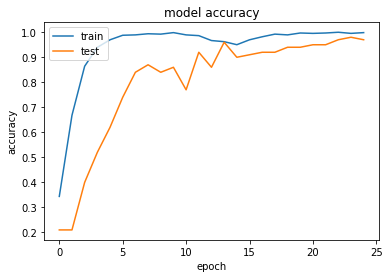

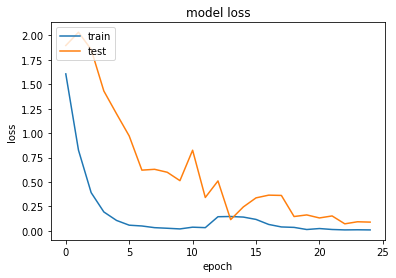

In [30]:
plot_loss_accuracy(model12)